# Libraries and Configurations

In [1]:
# GET DATA FROM DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# to process and visualize type data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# utilities
import os
import shutil
import random
import string

# fixed figure size
plt.rcParams["figure.figsize"] = (21, 12)

# to open zip file
from zipfile import ZipFile

In [3]:
import tensorflow as tf

# image preprocessing
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img

# to build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.activations import softmax

# cost function / optimizer
from tensorflow.keras.optimizers import Adam

In [4]:
# font configuration, because i am control freak
SMALL_SIZE = 12
MED_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE)
plt.rc("axes", labelsize=MED_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Process and Prepare Data

In [5]:
ZIP_PATH = "/content/drive/MyDrive/Datasets/poke.zip"
CSV_PATH = "/content/Pokemon.csv"

In [6]:
def OpenZip(path, destination=None):
  """
  Args: 
       path : a `str` type that represents location of zipfile
       destination : a `str` type that represents where to extract the zipfile
  Returns:
        None
        
  Extract zip file to desired location
  """
  with ZipFile(path, "r") as f:
    print("Extracting files...")
    f.extractall(destination)
    print("Done!")

In [7]:
OpenZip(ZIP_PATH, destination="/content/")

Extracting files...
Done!


In [8]:
# path to extracted main folder of zip file
ROOT_PATH = "/content/pokemon"

In [9]:
generations = os.listdir(ROOT_PATH)
generations

['icons', 'sugimori', 'overworld', 'conquest', 'main-sprites']

In [10]:
# create a new folder
BASE_DIR = "/content/Pokemons"

# create two subfolders in base dir
TRAIN_DIR = os.path.join(BASE_DIR, "training")
VAL_DIR = os.path.join(BASE_DIR, "validation")

# if cell is run multiple times, empty tree
if os.path.exists(BASE_DIR):
  shutil.rmtree(BASE_DIR)

os.makedirs(BASE_DIR)
os.makedirs(TRAIN_DIR)
os.makedirs(VAL_DIR)

In [11]:
# read csv file in order to get types for each pokemon according to their id number
df = pd.read_csv(CSV_PATH)
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [12]:
# there are 800 pokemons and 13 feature types in csv file
df.shape

(800, 13)

In [13]:
# get a list of type 1s for labels
pokemon_types = df["Type 1"].unique()
pokemon_types

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [14]:
# create subfolders for each type 1 in both training and validation folders 
for t in pokemon_types:
  os.makedirs(os.path.join(TRAIN_DIR, t))
  os.makedirs(os.path.join(VAL_DIR, t))
print("Type directories are created!")

Type directories are created!


In [15]:
# count pokemons in each subfolder

count_pokemons = {"conquest": 0,
                  "icons": 0,
                  "main-sprites": 0,
                  "overworld": 0,
                  "sugimori": 0}

for subfolder in os.listdir(ROOT_PATH):
  sub = os.path.join(ROOT_PATH, subfolder)
  for im in os.listdir(sub):
    count_pokemons[subfolder] += 1
    #print(im)

count_pokemons
# main-sprites and overworld folder has subdirectories.
# handle them separately

{'conquest': 202,
 'icons': 945,
 'main-sprites': 13,
 'overworld': 6,
 'sugimori': 852}

In [16]:
def create_type_path_lists(base_dir):
  """ 
  Args: 
      base_dir : a `str` that represents main folder
  Returns:
      A `dict` that `str` keys are pokemon types and `list` values are containing location of corresponding pokemon path

  Create lists for each pokemon type that contains corresponding type of pokemon path
  """
  
  alphabet = list(string.ascii_lowercase)

  type_lists_dict = {}
  for t in pokemon_types:
    type_lists_dict[t] = []

  if base_dir.split("/")[-1] in ["main-sprites", "overworld"]:
    for subfolder in os.listdir(base_dir):
      foldername = os.path.join(base_dir, subfolder)
      for filename in os.listdir(foldername):
        # eliminate pokemons that contains hyphen names like: 423-west.png
        if filename.split(".")[0].endswith(tuple(alphabet)):     
          #print("Excluded: ", im)
          continue
        if not os.path.isdir(os.path.join(foldername, filename)):
          # check if it is a folder or not
          poke_id = int(filename.split(".")[0])
          type1 = df.iloc[poke_id-1]["Type 1"]
          type_lists_dict[type1].append(os.path.join(foldername, filename))
    return type_lists_dict

  for fname in os.listdir(base_dir):
    filename = os.path.join(base_dir, fname)
    # eliminate pokemons that contains hyphen names like: 423-west.png
    if filename.split(".")[0].endswith(tuple(alphabet)):     
      #print("Excluded: ", im)
      continue
    if not os.path.isdir(filename):
      # check if it is a folder or not
      poke_id = int(fname.split(".")[0])
      type1 = list(df[df["#"] == poke_id]["Type 1"])[0]
      type_lists_dict[type1].append(filename)
  return type_lists_dict

#conquest_type_path_dict = create_type_path_lists("/content/pokemon/conquest")
#sugimori_type_path_dict = create_type_path_lists("/content/pokemon/sugimori")
#icons_type_path_dict = create_type_path_lists("/content/pokemon/icons")
#main_sprites_type_path_dict = create_type_path_lists("/content/pokemon/main-sprites")
#overworld_type_path_dict = create_type_path_lists("/content/pokemon/overworld")

# works very well <3

In [17]:
# create type-path dictionaries for each subfolder and then print the amounts of type 1 in each folder

conquest_type_path_dict = create_type_path_lists("/content/pokemon/conquest")
sugimori_type_path_dict = create_type_path_lists("/content/pokemon/sugimori")
icons_type_path_dict = create_type_path_lists("/content/pokemon/icons")
main_sprites_type_path_dict = create_type_path_lists("/content/pokemon/main-sprites")
overworld_type_path_dict = create_type_path_lists("/content/pokemon/overworld")

for k in conquest_type_path_dict.keys():
  print(f"{k} has {len(conquest_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in sugimori_type_path_dict.keys():
  print(f"{k} has {len(sugimori_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in icons_type_path_dict.keys():
  print(f"{k} has {len(icons_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in main_sprites_type_path_dict.keys():
  print(f"{k} has {len(main_sprites_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in overworld_type_path_dict.keys():
  print(f"{k} has {len(overworld_type_path_dict[k])} paths.")

Grass has 14 paths.
Fire has 14 paths.
Water has 14 paths.
Bug has 15 paths.
Normal has 19 paths.
Poison has 9 paths.
Electric has 13 paths.
Ground has 9 paths.
Fairy has 0 paths.
Fighting has 8 paths.
Psychic has 16 paths.
Rock has 12 paths.
Ghost has 14 paths.
Ice has 10 paths.
Dragon has 12 paths.
Dark has 12 paths.
Steel has 9 paths.
Flying has 0 paths.

-----------------------------------

Grass has 66 paths.
Fire has 47 paths.
Water has 105 paths.
Bug has 63 paths.
Normal has 93 paths.
Poison has 28 paths.
Electric has 36 paths.
Ground has 30 paths.
Fairy has 17 paths.
Fighting has 25 paths.
Psychic has 47 paths.
Rock has 41 paths.
Ghost has 23 paths.
Ice has 23 paths.
Dragon has 24 paths.
Dark has 28 paths.
Steel has 22 paths.
Flying has 3 paths.

-----------------------------------

Grass has 66 paths.
Fire has 47 paths.
Water has 105 paths.
Bug has 63 paths.
Normal has 93 paths.
Poison has 28 paths.
Electric has 36 paths.
Ground has 30 paths.
Fairy has 17 paths.
Fighting has 2

In [18]:
# to empty directories if you run multiple times

#training paths
TR_PATHS = ["/content/Pokemons/training/Bug",
            "/content/Pokemons/training/Dark",
            "/content/Pokemons/training/Dragon",
            "/content/Pokemons/training/Electric",
            "/content/Pokemons/training/Fairy",
            "/content/Pokemons/training/Fighting",
            "/content/Pokemons/training/Fire",
            "/content/Pokemons/training/Flying",
            "/content/Pokemons/training/Ghost",
            "/content/Pokemons/training/Grass",
            "/content/Pokemons/training/Ice",
            "/content/Pokemons/training/Normal",
            "/content/Pokemons/training/Poison",
            "/content/Pokemons/training/Psychic",
            "/content/Pokemons/training/Rock",
            "/content/Pokemons/training/Steel",
            "/content/Pokemons/training/Water",
            ]

# val paths
VL_PATHS = ["/content/Pokemons/validation/Bug",
            "/content/Pokemons/validation/Dark",
            "/content/Pokemons/validation/Dragon",
            "/content/Pokemons/validation/Electric",
            "/content/Pokemons/validation/Fairy",
            "/content/Pokemons/validation/Fighting",
            "/content/Pokemons/validation/Fire",
            "/content/Pokemons/validation/Flying",
            "/content/Pokemons/validation/Ghost",
            "/content/Pokemons/validation/Grass",
            "/content/Pokemons/validation/Ice",
            "/content/Pokemons/validation/Normal",
            "/content/Pokemons/validation/Poison",
            "/content/Pokemons/validation/Psychic",
            "/content/Pokemons/validation/Rock",
            "/content/Pokemons/validation/Steel",
            "/content/Pokemons/validation/Water",
            ]

for i in range(17):
  if len(os.listdir(TR_PATHS[i])) > 0:
    for file in os.scandir(TR_PATHS[i]):
      if file.path.split("/")[-1] != '.ipynb_checkpoints':
        os.remove(file.path)

  if len(os.listdir(VL_PATHS[i])) > 0:
    for file in os.scandir(VL_PATHS[i]):
      if file.path.split("/")[-1] != '.ipynb_checkpoints':
        os.remove(file.path)

In [19]:
def split_data(base_dir, type_path_dict, split_size):
  """
  Args:
      base_dir: a `str` that represents main folder
      type_path_dict: a `dict` of `list`s that contains type-path pairs
      split_size: a `float` that is ratio of train-val split
  
  Returns:
      None

  Gets type_path_dict, if image len is not zero, appends it to training or validation folders by shuffling types
  Fills training and validation folders by shuffled and splitted images
  """

  to_train_dir = os.path.join(base_dir, "training")
  to_val_dir = os.path.join(base_dir, "validation")
  
  for type_key in type_path_dict.keys():
    tmp_type_files = []
    type_files = type_path_dict[type_key]

    for f in type_files:
      if os.path.getsize(f):
        tmp_type_files.append(f)
      elif f == "/content/pokemon/main-sprites/black-white/0.png":
        print("Fucking egg found! : ", f)
        continue
      else:
        print("{} is zero length, so ignoring.".format(f))
    n_type = len(tmp_type_files)
    split_point = int(split_size * n_type)
    shuffled = random.sample(tmp_type_files, n_type)

    train_type = shuffled[:split_point]
    test_type = shuffled[split_point:]
    
    for type_path in train_type:
      to_copy = os.path.join(to_train_dir, type_key)
      copy_name = "".join(type_path.split("/")[3:])
      shutil.copyfile(type_path, os.path.join(to_copy, copy_name))
    
    for type_path in test_type:
      to_copy = os.path.join(to_val_dir, type_key)
      copy_name = "".join(type_path.split("/")[3:])
      shutil.copyfile(type_path, os.path.join(to_copy, copy_name))

In [20]:
# declare train-val ratio and then split data
split_size = 0.7

split_data(BASE_DIR, conquest_type_path_dict, split_size)
split_data(BASE_DIR, sugimori_type_path_dict, split_size)
split_data(BASE_DIR, icons_type_path_dict, split_size)
split_data(BASE_DIR, main_sprites_type_path_dict, split_size)
split_data(BASE_DIR, overworld_type_path_dict, split_size)

In [21]:
# save my preciousss data
shutil.make_archive("ProcessedPokemonData" + str(split_size)[2:], 'zip', "/content/Pokemons")

'/content/ProcessedPokemonData7.zip'

In [22]:
# observe training and validation splits
for i in range(17):
  print(f"There are {len(os.listdir(TR_PATHS[i]))} images of {(TR_PATHS[i].split('/')[-1].lower())}'s for training")
  print(f"There are {len(os.listdir(VL_PATHS[i]))} images of {(VL_PATHS[i].split('/')[-1].lower())}'s for validation.")
  print()

There are 513 images of bug's for training
There are 223 images of bug's for validation.

There are 150 images of dark's for training
There are 68 images of dark's for validation.

There are 149 images of dragon's for training
There are 68 images of dragon's for validation.

There are 287 images of electric's for training
There are 125 images of electric's for validation.

There are 91 images of fairy's for training
There are 43 images of fairy's for validation.

There are 176 images of fighting's for training
There are 79 images of fighting's for validation.

There are 383 images of fire's for training
There are 169 images of fire's for validation.

There are 4 images of flying's for training
There are 2 images of flying's for validation.

There are 154 images of ghost's for training
There are 68 images of ghost's for validation.

There are 478 images of grass's for training
There are 208 images of grass's for validation.

There are 137 images of ice's for training
There are 60 images

In [23]:
# create training and validation data generators

def train_val_generators(train_dir, val_dir):
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  train_gen = ImageDataGenerator(rescale=1/255.)
  val_gen = ImageDataGenerator(rescale=1/255.)

  train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                  batch_size=32,
                                                  class_mode="categorical",
                                                  target_size=(32, 32))
  val_generator = val_gen.flow_from_directory(directory=val_dir,
                                              batch_size=32,
                                              class_mode="categorical",
                                              target_size=(32, 32))
  return train_generator, val_generator

In [24]:
# paths to training and validation data

train_dir = "/content/Pokemons/training"
val_dir = "/content/Pokemons/validation"

In [31]:
# create a model

def create_model():
  model = Sequential([Conv2D(32, (3,3), input_shape=(32, 32, 3), activation="relu"),
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                      
                               Conv2D(32, (3,3), activation="relu"),
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                               
                               Flatten(),
                               Dense(128, activation="relu"),
                               Dense(18, activation="softmax")
                               ])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [26]:
# load the best resulted randomly shuffled-splitted data
OpenZip("/content/drive/MyDrive/Datasets/ProcessedPokemonData7_split1.zip", "/content/loaded_data")

Extracting files...
Done!


In [32]:
loaded_train_dir = os.path.join("/content/loaded_data", "training")
loaded_val_dir = os.path.join("/content/loaded_data", "validation")

In [33]:
tf.keras.backend.clear_session()

train_generator, val_generator = train_val_generators(loaded_train_dir, loaded_val_dir)   # create image generators to feed images to the model
model = create_model()

print("\n[INFO] Ready to train. Training is starting!\n")

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)   # limitation to stop somewhere early

hist = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=[callback])

Found 7148 images belonging to 18 classes.
Found 4072 images belonging to 18 classes.

[INFO] Ready to train. Training is starting!

Epoch 1/200
224/224 [==============================] - 41s 182ms/step - loss: 2.7972 - accuracy: 0.1392 - val_loss: 4.3944 - val_accuracy: 0.0648
Epoch 2/200
224/224 [==============================] - 34s 151ms/step - loss: 2.6150 - accuracy: 0.1663 - val_loss: 2.8664 - val_accuracy: 0.1179
Epoch 3/200
224/224 [==============================] - 34s 152ms/step - loss: 2.5742 - accuracy: 0.1763 - val_loss: 2.5321 - val_accuracy: 0.1898
Epoch 4/200
224/224 [==============================] - 35s 157ms/step - loss: 2.5201 - accuracy: 0.1946 - val_loss: 2.4602 - val_accuracy: 0.2134
Epoch 5/200
224/224 [==============================] - 34s 151ms/step - loss: 2.4493 - accuracy: 0.2133 - val_loss: 2.3676 - val_accuracy: 0.2463
Epoch 6/200
224/224 [==============================] - 35s 157ms/step - loss: 2.3616 - accuracy: 0.2415 - val_loss: 2.2922 - val_accuracy

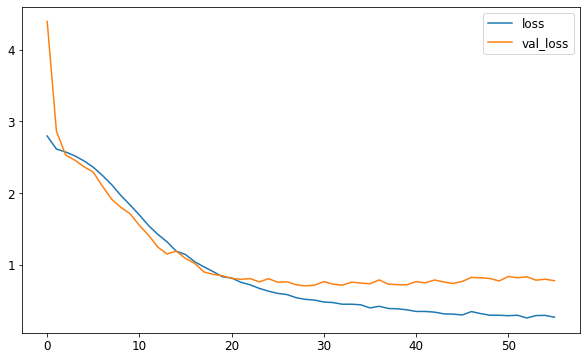

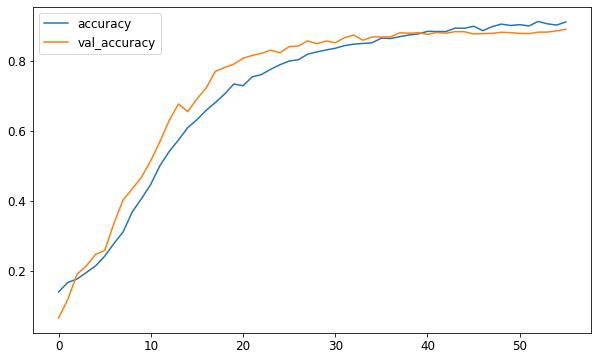

In [34]:
# plot the results

eps = range(len(hist.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["loss"])
plt.plot(eps, hist.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["accuracy"])
plt.plot(eps, hist.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

In [35]:
# save the model <3
model.save("PokemonTrainerDropout20.h5")

# download it to local
from google.colab import files
files.download("PokemonTrainerDropout20.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>